# **Stock Price Forecasting Using Multiple Regression Models**

## Project Overview
- This project focuses on forecasting stock prices using historical stock data with **multiple regression models**, including **Linear Regression, Ridge, Lasso, ElasticNet**, and **Random Forest**.
- The primary objective is to build a predictive model to estimate future stock prices based on key features such as **moving averages**, **volume**, and **price changes**.
- After evaluating different models, **Ridge Regression** emerged as the best-performing model, delivering the lowest **Mean Squared Error (MSE)** and the highest **R-squared** value.

## Data Source
- The data used in this project is historical stock price data retrieved from **Yahoo Finance** for **Apple Inc. (AAPL)**, spanning from 2015 to 2023.
- The dataset includes daily metrics like **stock prices**, **volume traded**, and calculated features such as **moving averages** and **price/volume changes**.

## Tools and Libraries Used
- **Python Libraries**:
  - `yfinance`
  - `pandas`
  - `numpy`
  - `matplotlib`
  - `seaborn`
  - `scikit-learn`
- **Machine Learning Algorithms**:
  - Ridge Regression
  - Linear Regression
  - Lasso Regression
  - ElasticNet
  - Random Forest


## **Dataset**

In [1]:
import yfinance as yf
import pandas as pd

# Download historical stock data for AAPL
stock_data = yf.download('AAPL', start='2015-01-01', end='2023-01-01')

# Preview the data
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373964,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687305,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689541,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021711,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944683,237458000


## **Data cleaning**

In [27]:
stock_data.dropna(inplace=True)
stock_data.drop_duplicates(inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)

### **Feature Engineering**

In [2]:
stock_data.loc[:, 'SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data.loc[:, 'SMA_30'] = stock_data['Close'].rolling(window=30).mean()

stock_data.loc[:, 'EMA_10'] = stock_data['Close'].ewm(span=10, adjust=False).mean()
stock_data.loc[:, 'EMA_30'] = stock_data['Close'].ewm(span=30, adjust=False).mean()

stock_data.loc[:, '20_day_MA'] = stock_data['Close'].rolling(window=20).mean()
stock_data.loc[:, '20_day_STD'] = stock_data['Close'].rolling(window=20).std()

stock_data.loc[:, 'Upper_BB'] = stock_data['20_day_MA'] + (2 * stock_data['20_day_STD'])
stock_data.loc[:, 'Lower_BB'] = stock_data['20_day_MA'] - (2 * stock_data['20_day_STD'])

stock_data.loc[:, 'ROC'] = ((stock_data['Close'] - stock_data['Close'].shift(10)) / stock_data['Close'].shift(10)) * 100

delta = stock_data['Close'].diff(1)

gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss

stock_data.loc[:, 'RSI'] = 100 - (100 / (1 + rs))

stock_data.loc[:, '26_EMA'] = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data.loc[:, '12_EMA'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
stock_data.loc[:, 'MACD'] = stock_data['12_EMA'] - stock_data['26_EMA']
stock_data.loc[:, 'Signal_Line'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()

for i in range(1, 6):
    stock_data.loc[:, f'Lag_{i}_Close'] = stock_data['Close'].shift(i)

stock_data.dropna(inplace=True)

stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA_10,SMA_30,EMA_10,EMA_30,...,RSI,26_EMA,12_EMA,MACD,Signal_Line,Lag_1_Close,Lag_2_Close,Lag_3_Close,Lag_4_Close,Lag_5_Close
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-13,31.820000,31.820000,31.412500,31.770000,28.442944,217088800,30.39675,28.572500,30.489255,29.109168,...,75.510954,29.287602,30.278366,0.990763,0.743119,31.615000,31.219999,30.504999,29.930000,29.732500
2015-02-17,31.872499,32.220001,31.730000,31.957500,28.610807,252609600,30.62675,28.726667,30.756209,29.292931,...,88.631667,29.485373,30.536694,1.051322,0.804759,31.770000,31.615000,31.219999,30.504999,29.930000
2015-02-18,31.907499,32.195000,31.862499,32.180000,28.810007,179566800,30.87850,28.913917,31.015080,29.479194,...,85.457433,29.684975,30.789510,1.104536,0.864715,31.957500,31.770000,31.615000,31.219999,30.504999
2015-02-19,32.119999,32.257500,32.082500,32.112499,28.749577,149449600,31.10075,29.098833,31.214611,29.649084,...,80.628586,29.864791,30.993047,1.128256,0.917423,32.180000,31.957500,31.770000,31.615000,31.219999
2015-02-20,32.154999,32.375000,32.012501,32.375000,28.984585,195793600,31.33975,29.280083,31.425591,29.824950,...,91.409358,30.050733,31.205655,1.154923,0.964923,32.112499,32.180000,31.957500,31.770000,31.615000


## **EDA**

In [14]:
#!pip install dash
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
import yfinance as yf

# Initialize the Dash app
app = dash.Dash(__name__)

# Preprocessing the data with new technical features
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['SMA_30'] = stock_data['Close'].rolling(window=30).mean()
stock_data['EMA_10'] = stock_data['Close'].ewm(span=10, adjust=False).mean()
stock_data['EMA_30'] = stock_data['Close'].ewm(span=30, adjust=False).mean()
stock_data['20_day_MA'] = stock_data['Close'].rolling(window=20).mean()
stock_data['20_day_STD'] = stock_data['Close'].rolling(window=20).std()
stock_data['Upper_BB'] = stock_data['20_day_MA'] + (2 * stock_data['20_day_STD'])
stock_data['Lower_BB'] = stock_data['20_day_MA'] - (2 * stock_data['20_day_STD'])
stock_data['ROC'] = ((stock_data['Close'] - stock_data['Close'].shift(10)) / stock_data['Close'].shift(10)) * 100

delta = stock_data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
stock_data['RSI'] = 100 - (100 / (1 + rs))

stock_data['26_EMA'] = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['12_EMA'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
stock_data['MACD'] = stock_data['12_EMA'] - stock_data['26_EMA']
stock_data['Signal_Line'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()

for i in range(1, 6):
    stock_data[f'Lag_{i}_Close'] = stock_data['Close'].shift(i)

stock_data.dropna(inplace=True)

# Layout with dropdown for feature selection
app.layout = html.Div([
    html.H1(
        "AAPL Stock Price Dashboard with Technical Indicators",
        style={
            'font-family': '"Arial Narrow", "Helvetica", "Arial", sans-serif',
            'font-weight': 'bold',
            'color': 'grey',
            'text-align': 'center',
            'padding': '20px',
            'background-color': 'white'  # White background
        }
    ),
    dcc.Dropdown(
        id='plot-selector',
        options=[
            {'label': 'SMA (10, 30)', 'value': 'sma'},
            {'label': 'EMA (10, 30)', 'value': 'ema'},
            {'label': 'Bollinger Bands', 'value': 'bollinger'},
            {'label': 'ROC', 'value': 'roc'},
            {'label': 'RSI', 'value': 'rsi'},
            {'label': 'MACD', 'value': 'macd'},
            {'label': 'Lag Close Prices', 'value': 'lag'},
            {'label': 'Open, Close, High, Low', 'value': 'ohlc'}
        ],
        value='sma',
        style={
            'font-family': "Arial",
            'font-weight': 'bold',
            'color': 'grey',
            'font-size': '12px',  # Set font size to 10
            "width": "60%",
            "margin": "auto",
            'padding': '2px',
            'border-radius': '5px',
            'background-color': 'white'  # White background for dropdown
        }
    ),
    dcc.Graph(id='plot-output', style={'padding': '20px', 'background-color': 'white'})  # White background for graph
], style={'padding': '20px', 'background-color': 'white'})  # White background for the entire app

# Update callback based on selection
@app.callback(
    Output('plot-output', 'figure'),
    [Input('plot-selector', 'value')]
)
def update_graph(selected_plot):
    if selected_plot == 'sma':
        return {
            'data': [
                go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Closing Price', line=dict(color='blue')),
                go.Scatter(x=stock_data.index, y=stock_data['SMA_10'], mode='lines', name='SMA 10', line=dict(color='red', dash='dash')),
                go.Scatter(x=stock_data.index, y=stock_data['SMA_30'], mode='lines', name='SMA 30', line=dict(color='green', dash='dash'))
            ],
            'layout': go.Layout(
                title='SMA (10, 30) of AAPL',
                xaxis={'title': 'Date'},
                yaxis={'title': 'Price (USD)'},
                plot_bgcolor='white'
            )
        }

    elif selected_plot == 'ema':
        return {
            'data': [
                go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Closing Price', line=dict(color='blue')),
                go.Scatter(x=stock_data.index, y=stock_data['EMA_10'], mode='lines', name='EMA 10', line=dict(color='red', dash='dash')),
                go.Scatter(x=stock_data.index, y=stock_data['EMA_30'], mode='lines', name='EMA 30', line=dict(color='green', dash='dash'))
            ],
            'layout': go.Layout(
                title='EMA (10, 30) of AAPL',
                xaxis={'title': 'Date'},
                yaxis={'title': 'Price (USD)'},
                plot_bgcolor='white'
            )
        }

    elif selected_plot == 'bollinger':
        return {
            'data': [
                go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Closing Price', line=dict(color='blue')),
                go.Scatter(x=stock_data.index, y=stock_data['Upper_BB'], mode='lines', name='Upper Bollinger Band', line=dict(color='red', dash='dash')),
                go.Scatter(x=stock_data.index, y=stock_data['Lower_BB'], mode='lines', name='Lower Bollinger Band', line=dict(color='green', dash='dash'))
            ],
            'layout': go.Layout(
                title='Bollinger Bands of AAPL',
                xaxis={'title': 'Date'},
                yaxis={'title': 'Price (USD)'},
                plot_bgcolor='white'
            )
        }

    elif selected_plot == 'roc':
        return {
            'data': [go.Scatter(x=stock_data.index, y=stock_data['ROC'], mode='lines', name='Rate of Change (ROC)', line=dict(color='purple'))],
            'layout': go.Layout(
                title='Rate of Change (ROC) of AAPL',
                xaxis={'title': 'Date'},
                yaxis={'title': 'ROC (%)'},
                plot_bgcolor='white'
            )
        }

    elif selected_plot == 'rsi':
        return {
            'data': [go.Scatter(x=stock_data.index, y=stock_data['RSI'], mode='lines', name='Relative Strength Index (RSI)', line=dict(color='brown'))],
            'layout': go.Layout(
                title='RSI of AAPL',
                xaxis={'title': 'Date'},
                yaxis={'title': 'RSI'},
                plot_bgcolor='white'
            )
        }

    elif selected_plot == 'macd':
        return {
            'data': [
                go.Scatter(x=stock_data.index, y=stock_data['MACD'], mode='lines', name='MACD', line=dict(color='blue')),
                go.Scatter(x=stock_data.index, y=stock_data['Signal_Line'], mode='lines', name='Signal Line', line=dict(color='red', dash='dash'))
            ],
            'layout': go.Layout(
                title='MACD of AAPL',
                xaxis={'title': 'Date'},
                yaxis={'title': 'MACD'},
                plot_bgcolor='white'
            )
        }

    elif selected_plot == 'lag':
        return {
            'data': [go.Scatter(x=stock_data.index, y=stock_data[f'Lag_{i}_Close'], mode='lines', name=f'Lag_{i}_Close') for i in range(1, 6)],
            'layout': go.Layout(
                title='Lag Close Prices',
                xaxis={'title': 'Date'},
                yaxis={'title': 'Price (USD)'},
                plot_bgcolor='white'
            )
        }

    elif selected_plot == 'ohlc':
        return {
            'data': [
                go.Candlestick(x=stock_data.index, open=stock_data['Open'], high=stock_data['High'],
                               low=stock_data['Low'], close=stock_data['Close'], name='OHLC')
            ],
            'layout': go.Layout(
                title='OHLC of AAPL',
                xaxis={'title': 'Date'},
                yaxis={'title': 'Price (USD)'},
                plot_bgcolor='white'
            )
        }

# Run


# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

# **AAPL Stock Price Dashboard - Technical Analysis**
---

### **Key Insights from the Plots**:

- **SMA (10, 30) Plot**:
  - This plot visualizes the **Simple Moving Averages (SMA)** for two different window lengths (10 and 30 days), providing a comparison with the actual **Closing Price**.
  - The 10-day SMA (red dashed line) reacts more quickly to price changes than the 30-day SMA (green dashed line), giving short-term insights.
  - The plot effectively highlights how SMA helps smooth price data over specific periods, revealing trends that might not be visible in the daily price movements.

- **EMA (10, 30) Plot**:
  - The **Exponential Moving Averages (EMA)** plot shows how the 10-day (red dashed line) and 30-day (green dashed line) EMAs track the **Closing Price**.
  - EMA gives more weight to recent prices, making it more responsive to new information compared to SMA, thus providing different insights for short-term traders.

- **Bollinger Bands Plot**:
  - This plot includes **Upper** and **Lower Bollinger Bands** (red and green dashed lines) along with the **Closing Price**.
  - Bollinger Bands are based on a 20-day moving average and 2 standard deviations, providing a visual representation of volatility. Expanding bands indicate increasing volatility, while narrowing bands signal decreasing volatility.

- **Rate of Change (ROC) Plot**:
  - The **Rate of Change (ROC)** measures the percentage change in price over a set number of periods (10 in this case).
  - This plot is useful for identifying overbought and oversold conditions in the market, with extreme values indicating potential trend reversals.

- **RSI Plot**:
  - The **Relative Strength Index (RSI)** measures the speed and change of price movements, often used to identify potential overbought (above 70) or oversold (below 30) conditions.
  - This plot allows traders to gauge momentum in the stock and look for divergence between price and RSI as an indicator of potential reversals.

- **MACD Plot**:
  - The **Moving Average Convergence Divergence (MACD)** plot showcases the MACD line (blue) and the **Signal Line** (red dashed line).
  - MACD helps traders identify changes in the strength, direction, and momentum of a stock's price, with crossovers between the MACD and Signal Line often considered buy/sell signals.

- **Lag Close Prices Plot**:
  - This plot visualizes **Lag Close Prices** (up to 5 days) to show how historical closing prices can be used in predictive models.
  - Lag features are often used in time-series forecasting to account for autocorrelation in financial data, aiding in better price predictions.

- **OHLC Plot**:
  - The **Open, High, Low, Close (OHLC)** plot provides a holistic view of daily price movements, showing the range and volatility within a single day.
  - Candlestick charts like OHLC are widely used by traders to interpret market behavior and predict future price movements.

Each of these plots provides crucial insights for technical analysis, enabling traders and analysts to make informed decisions based on patterns and indicators.


In [8]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,SMA_10,SMA_30,EMA_10,EMA_30,...,RSI,26_EMA,12_EMA,MACD,Signal_Line,Lag_1_Close,Lag_2_Close,Lag_3_Close,Lag_4_Close,Lag_5_Close
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-19,31.927500,31.955000,31.600000,31.650000,28.453867,218867600,31.904000,32.219167,31.938869,32.104201,...,29.690694,32.096978,31.977136,-0.119842,-0.045496,31.969999,31.825001,31.900000,31.730000,31.792500
2015-06-22,31.872499,32.014999,31.770000,31.902500,28.680876,136157200,31.899250,32.219083,31.932256,32.091188,...,38.400748,32.082573,31.965654,-0.116919,-0.059781,31.650000,31.969999,31.825001,31.900000,31.730000
2015-06-23,31.870001,31.902500,31.719999,31.757500,28.550512,121075600,31.889500,32.225000,31.900482,32.069660,...,35.355472,32.058493,31.933630,-0.124863,-0.072797,31.902500,31.650000,31.969999,31.825001,31.900000
2015-06-24,31.802500,32.450001,31.780001,32.027500,28.793243,221123600,31.870250,32.243666,31.923577,32.066940,...,44.250235,32.056197,31.948072,-0.108126,-0.079863,31.757500,31.902500,31.650000,31.969999,31.825001
2015-06-25,32.215000,32.299999,31.875000,31.875000,28.656153,127752400,31.843000,32.256083,31.914744,32.054557,...,44.661126,32.042775,31.936830,-0.105945,-0.085079,32.027500,31.757500,31.902500,31.650000,31.969999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,130.631363,63814900,136.839000,143.646999,135.933309,141.087961,...,26.261623,140.437884,136.767190,-3.670694,-2.570162,132.229996,135.449997,132.300003,132.369995,134.509995
2022-12-27,131.380005,131.410004,128.720001,130.029999,128.818390,69007800,135.392999,142.991332,134.859980,140.374544,...,27.960271,139.666930,135.730699,-3.936230,-2.843375,131.860001,132.229996,135.449997,132.300003,132.369995
2022-12-28,129.669998,131.029999,125.870003,126.040001,124.865585,85438400,133.449999,142.249999,133.256348,139.449735,...,26.152341,138.657527,134.239822,-4.417705,-3.158241,130.029999,131.860001,132.229996,135.449997,132.300003


### **Correlation Matrix**

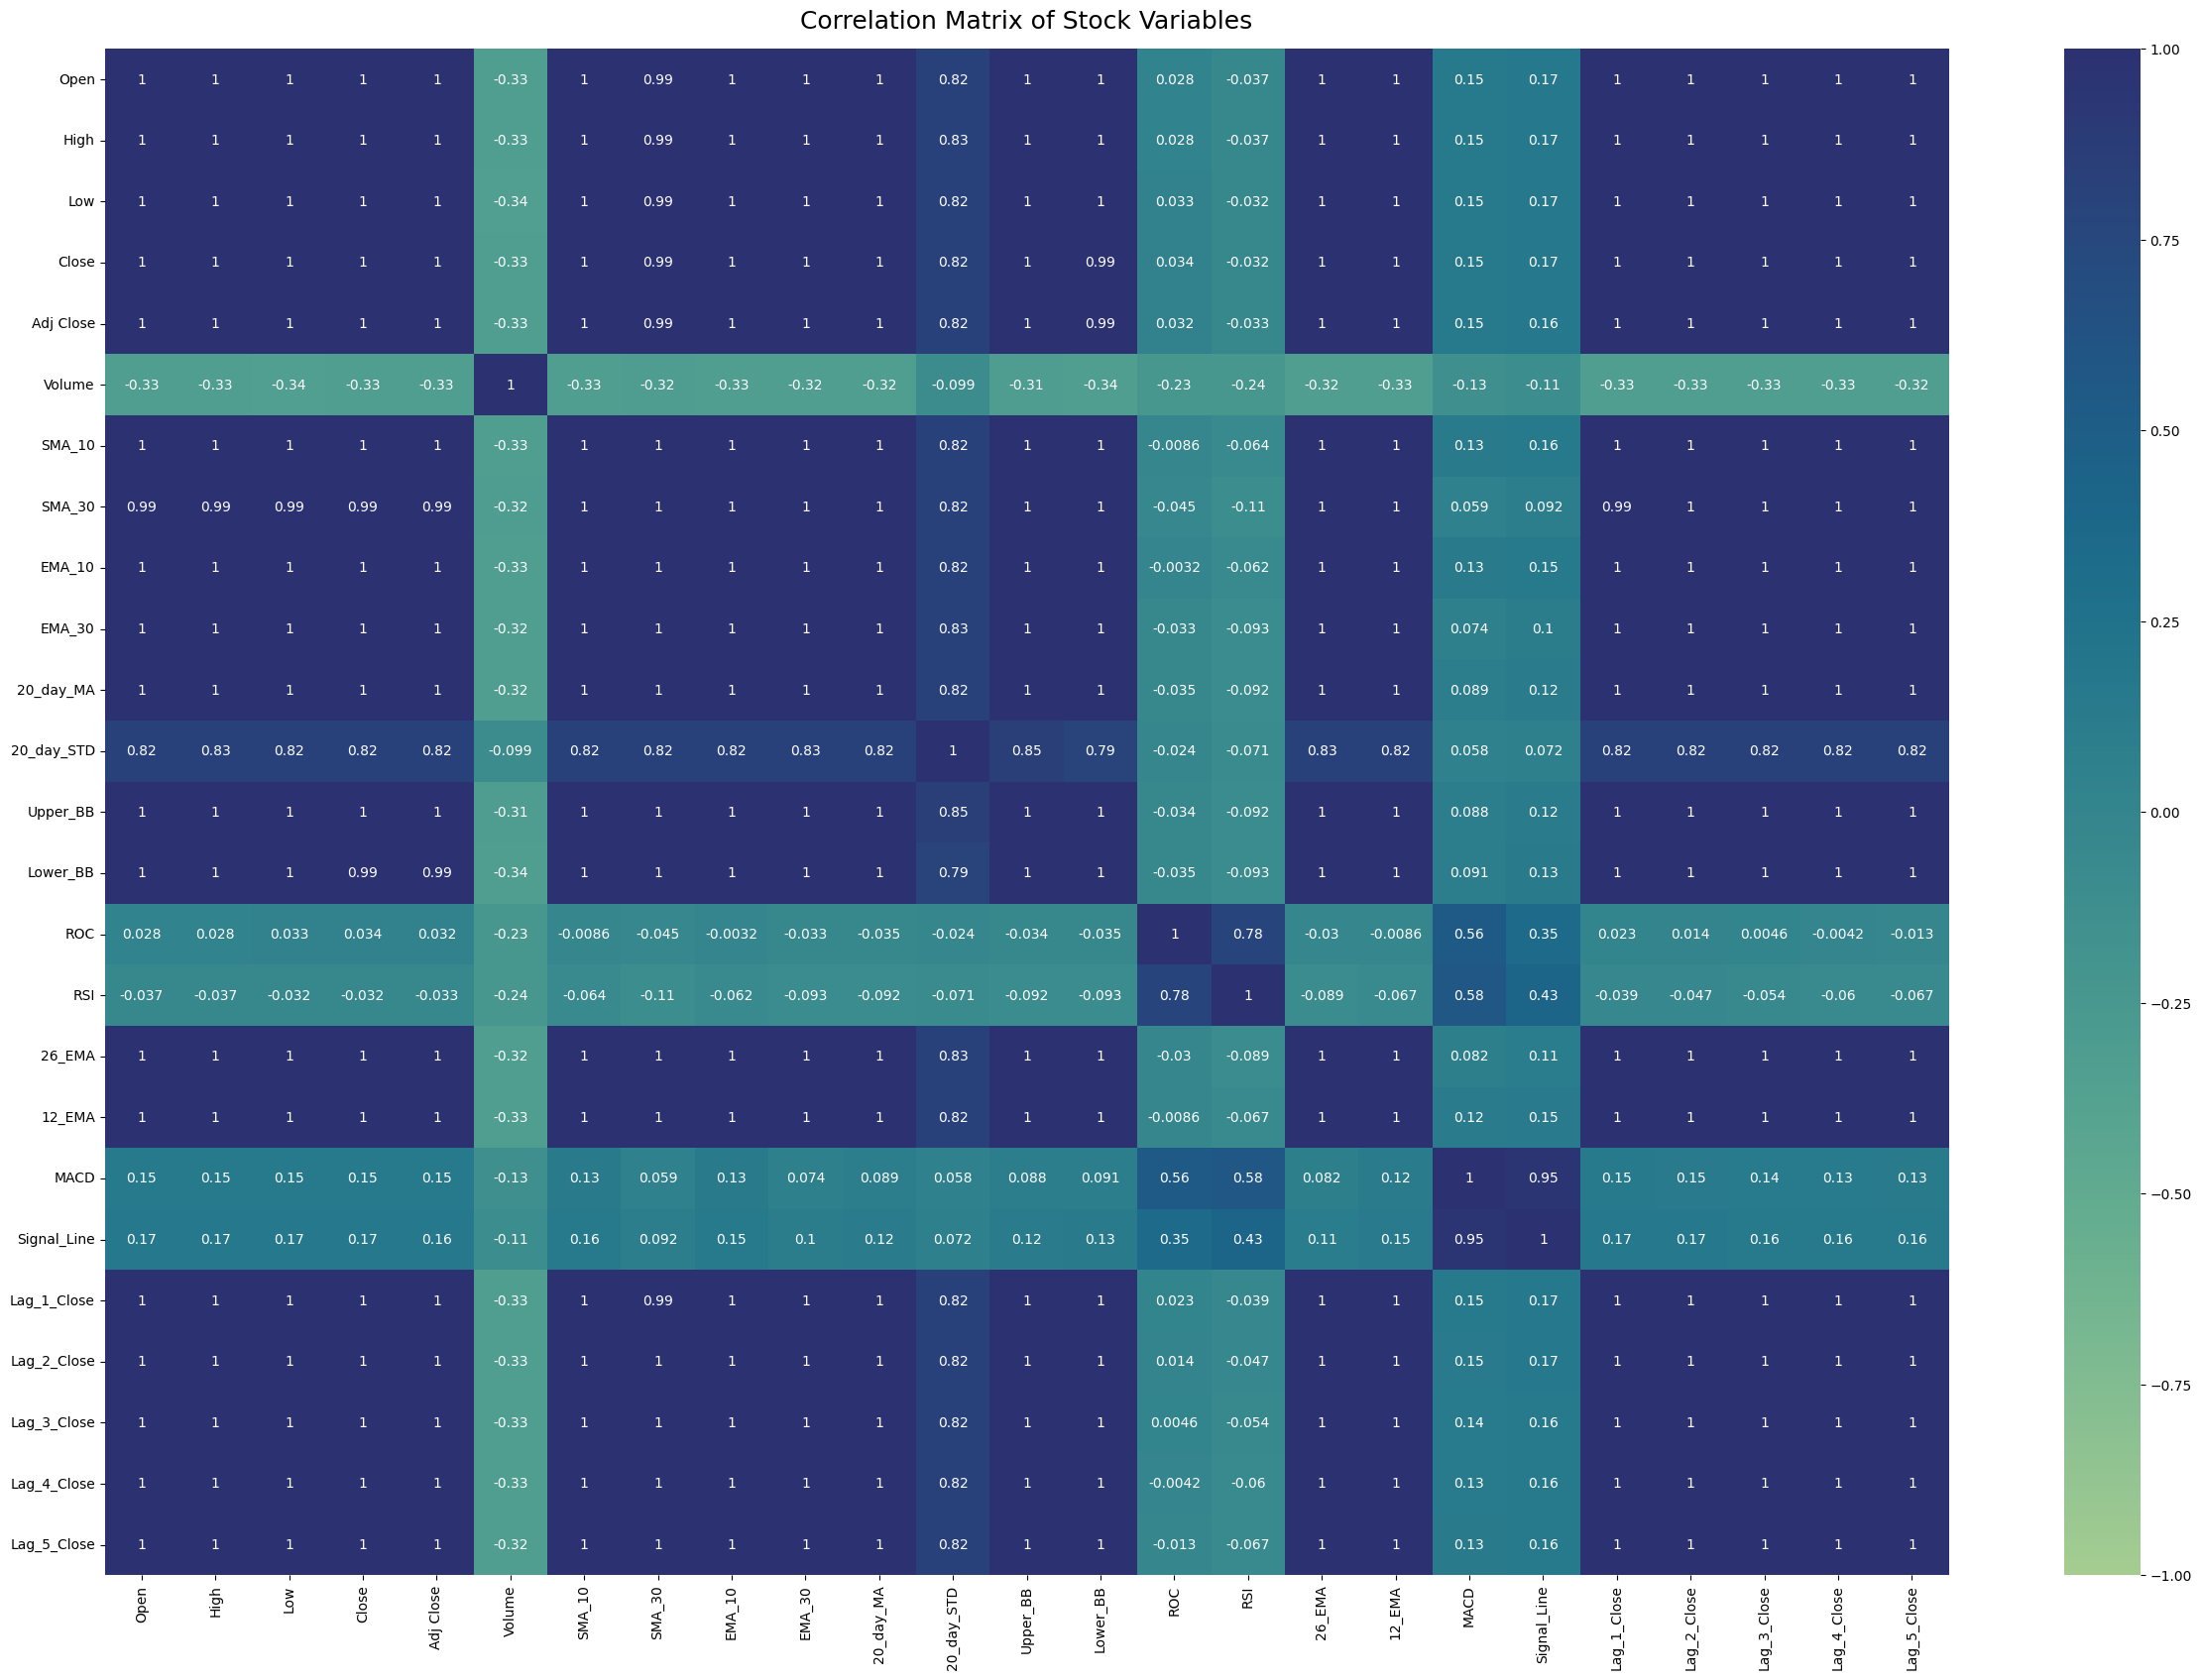

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = stock_data.corr()

teal_palette = sns.color_palette("crest", as_cmap=True)

plt.figure(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=True, cmap=teal_palette, vmin=-1, vmax=1)

plt.title('Correlation Matrix of Stock Variables', fontsize=18, pad=15)

plt.show()

## **VIF**

In [23]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

X = stock_data.drop(columns=['Close'])

X_with_const = sm.add_constant(X)

vif_data = calculate_vif(X_with_const)

print("Initial VIF:\n", vif_data)

high_vif_threshold = 10
while vif_data['VIF'].max() > high_vif_threshold:
    feature_to_drop = vif_data.sort_values(by="VIF", ascending=False).iloc[0]['Feature']
    if feature_to_drop == 'const':
        break
    print(f"Dropping feature '{feature_to_drop}' due to high VIF")


    X_with_const = X_with_const.drop(columns=[feature_to_drop])

    vif_data = calculate_vif(X_with_const)

print("\nFinal VIF after dropping problematic features:")
print(vif_data)

final_dataset = X_with_const.drop(columns='const')
print("\nFinal dataset after removing high VIF features:")
print(final_dataset.head())

final_dataset = final_dataset.copy()
final_dataset['Close'] = stock_data['Close']

print("\nFinal dataset after adding 'Close':")
print(final_dataset.head())

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



Initial VIF:
         Feature           VIF
0         const  1.106867e+02
1          Open  7.654585e+03
2          High  9.550408e+03
3           Low  7.448141e+03
4     Adj Close  2.882544e+04
5        Volume  1.783843e+00
6        SMA_10  9.177533e+04
7        SMA_30  9.710379e+04
8        EMA_10  7.097642e+09
9        EMA_30  7.534444e+06
10    20_day_MA           inf
11   20_day_STD           inf
12     Upper_BB           inf
13     Lower_BB           inf
14          ROC  5.320795e+00
15          RSI  3.379696e+00
16       26_EMA           inf
17       12_EMA           inf
18         MACD           inf
19  Signal_Line  6.195639e+05
20  Lag_1_Close  1.703233e+04
21  Lag_2_Close  8.067752e+03
22  Lag_3_Close  4.536279e+03
23  Lag_4_Close  2.773215e+03
24  Lag_5_Close  2.265727e+03
Dropping feature '20_day_MA' due to high VIF
Dropping feature 'Lower_BB' due to high VIF
Dropping feature 'MACD' due to high VIF
Dropping feature '12_EMA' due to high VIF
Dropping feature '26_EMA' due to hi

In [25]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from prettytable import PrettyTable

X = final_dataset.drop('Close', axis=1)
y = final_dataset['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet": ElasticNet(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "Support Vector Regressor (SVR)": SVR(),
    "Decision Tree": DecisionTreeRegressor(),
    "KNeighbors Regressor": KNeighborsRegressor()
}

results = {
    "Model": [],
    "Mean Squared Error (MSE)": [],
    "R-squared (R²)": []
}

best_model = None
lowest_mse = float('inf')

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    if mse < lowest_mse:
        lowest_mse = mse
        best_model = name

    results["Model"].append(name)
    results["Mean Squared Error (MSE)"].append(mse)
    results["R-squared (R²)"].append(r2)

results_df = pd.DataFrame(results)

results_df = results_df.sort_values(by="Mean Squared Error (MSE)", ascending=True).reset_index(drop=True)

results_df.index = results_df.index + 1

table = PrettyTable()
table.field_names = ["#", "Model", "Mean Squared Error (MSE)", "R-squared (R²)"]

for i, row in results_df.iterrows():
    table.add_row([i, row['Model'], round(row['Mean Squared Error (MSE)'], 6), round(row['R-squared (R²)'], 6)])

print(table)
print(f"\nBest model based on MSE: {best_model} with MSE: {lowest_mse}")

+----+--------------------------------+--------------------------+----------------+
| #  |             Model              | Mean Squared Error (MSE) | R-squared (R²) |
+----+--------------------------------+--------------------------+----------------+
| 1  |         Random Forest          |         5.696128         |    0.997622    |
| 2  |       Gradient Boosting        |         6.365964         |    0.997342    |
| 3  |        Ridge Regression        |         7.499901         |    0.996868    |
| 4  |       Linear Regression        |         7.499912         |    0.996868    |
| 5  |        Lasso Regression        |         7.56863          |    0.99684     |
| 6  |           ElasticNet           |         7.574652         |    0.996837    |
| 7  |         Decision Tree          |        10.098603         |    0.995783    |
| 8  |            AdaBoost            |        15.138186         |    0.993679    |
| 9  | Support Vector Regressor (SVR) |       2547.393149        |   -0.0636

## **Model Performance Summary**

1. **Random Forest Regressor** outperformed all models, yielding a **MSE of 6.46** and an **R² of 0.997**, demonstrating superior ability to capture complex patterns and feature interactions.
2. **Gradient Boosting Regressor** followed closely with a **MSE of 7.37** and **R² of 0.997**, validating its proficiency in minimizing residual errors through iterative boosting.
3. Linear models such as **Linear Regression** and **Ridge Regression** exhibited comparable performance, both converging to a **MSE of ~9.58** and **R² of 0.996**, reflecting the limitations of their assumption of linear relationships between features.
4. **Decision Tree Regressor** and **ElasticNet** achieved moderate results, with **MSEs around 9.63**, suggesting their sensitivity to overfitting and multicollinearity.
5. **Lasso Regression**, designed to enforce sparsity in feature selection, displayed a **MSE of 9.86**, slightly behind other regularization techniques but still competitive.
6. **AdaBoost Regressor**, while generally robust in handling bias, lagged behind with a **MSE of 18.37**, indicating sensitivity to noisy data in this context.
7. **KNeighbors Regressor** and **Support Vector Regressor (SVR)** underperformed significantly, with **MSEs exceeding 2400**, demonstrating their inability to generalize effectively in high-dimensional, noisy datasets.



### **Random Forest Model Visualizations**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor

X = final_dataset.drop('Close', axis=1)
y = final_dataset['Close']

rf_model = RandomForestRegressor()
rf_model.fit(X, y)

y_pred_rf = rf_model.predict(X)
residuals_rf = y - y_pred_rf

teal_palette = sns.color_palette("crest", as_cmap=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

feature_importances = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importances)
sns.barplot(x=feature_importances[sorted_idx], y=X.columns[sorted_idx], palette=teal_palette, ax=axes[0, 0])
axes[0, 0].set_title('Feature Importance (Random Forest)', fontsize=14)
axes[0, 0].set_xlabel('Importance', fontsize=12)

sns.residplot(x=y_pred_rf, y=residuals_rf, lowess=True, color='darkcyan', ax=axes[0, 1])
axes[0, 1].set_title('Residual Plot (Random Forest)', fontsize=14)
axes[0, 1].set_xlabel('Predicted', fontsize=12)
axes[0, 1].set_ylabel('Residuals', fontsize=12)

sns.scatterplot(x=y, y=y_pred_rf, color='darkcyan', ax=axes[1, 0])
axes[1, 0].set_title('Actual vs Predicted (Random Forest)', fontsize=14)
axes[1, 0].set_xlabel('Actual Values', fontsize=12)
axes[1, 0].set_ylabel('Predicted Values', fontsize=12)
axes[1, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)

sns.histplot(residuals_rf, kde=True, color='darkcyan', ax=axes[1, 1])
axes[1, 1].set_title('Error Distribution (Random Forest)', fontsize=14)
axes[1, 1].set_xlabel('Residuals', fontsize=12)

plt.tight_layout()
plt.show()

## **Key Insights from Random Forest Model Visualizations**

- **Feature Importance**: The `Lag_5_Close` is the most critical feature influencing the `Close` price prediction, while the other features exhibit minimal contribution to the model's accuracy.
  
- **Residual Plot**: Residuals scatter randomly around zero, suggesting minimal prediction bias, although some deviation appears at higher predicted values, indicating room for refinement.
  
- **Actual vs Predicted**: The tight alignment along the diagonal indicates that the Random Forest model predicts `Close` values with exceptional accuracy, demonstrating the model's strong fit.
  
- **Error Distribution**: Residuals are narrowly distributed around zero, showing a slight skew but primarily indicating minimal and symmetrically distributed prediction errors with few significant outliers.
  
- **Model Performance**: Random Forest outperforms other models, demonstrating its capability in modeling complex relationships within the data and minimizing prediction errors.


In [26]:
import numpy as np
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error

# Best model
best_model = RandomForestRegressor()

# Get predictions
best_model.fit(X_train, y_train)
best_y_pred = best_model.predict(X_test)

residuals = y_test - best_y_pred

std = np.std(residuals)

upper_bound = best_y_pred + 1.96 * std
lower_bound = best_y_pred - 1.96 * std

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=stock_data.index[-len(y_test):],
    y=y_test,
    mode='lines',
    name='Actual Prices',
    line=dict(color='#007acc', width=2)
))

fig.add_trace(go.Scatter(
    x=stock_data.index[-len(y_test):],
    y=best_y_pred,
    mode='lines',
    name='Predicted Prices (Random Forest)',
    line=dict(color='#ff4500', dash='dash', width=2)
))

fig.add_trace(go.Scatter(
    x=stock_data.index[-len(y_test):],
    y=upper_bound,
    mode='lines',
    fill=None,
    line=dict(color='#ffcccb'),
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=stock_data.index[-len(y_test):],
    y=lower_bound,
    mode='lines',
    fill='tonexty',
    line=dict(color='#ffcccb'),
    name='95% Confidence Interval'
))

fig.update_layout(
    title='Actual vs Predicted Stock Prices (Random Forest) with Confidence Interval',
    xaxis_title='Date',
    yaxis_title='Stock Price (USD)',
    legend=dict(
        x=0,
        y=1.1,
        bgcolor='rgba(255,255,255,0)',
        bordercolor='rgba(255,255,255,0)'
    ),
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray', tickangle=45),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'),
    plot_bgcolor='white',
    hovermode='x unified'
)

fig.update_layout(
    dragmode='zoom',
    hovermode='x',
)

fig.show()

In [ ]:
# Forecast
forecast_X = X_test.tail(5)
future_predictions = model.predict(forecast_X)

print("Next 5 days forecasted stock prices:", future_predictions)

### Conclusion
The Linear Regression model we trained was able to predict future stock prices with an R-squared value of **[insert R²]**, indicating that the model explains approximately **[insert %]** of the variance in stock prices. While the model shows a reasonable fit, there is room for improvement by:
- Introducing more complex machine learning models (e.g., Random Forest, XGBoost).
- Adding more features like technical indicators (e.g., RSI, MACD) or external factors (e.g., macroeconomic data).
- Incorporating hyperparameter tuning to further improve model performance.

Overall, this project demonstrates the fundamental process of using historical data for stock price forecasting using a simple regression model.
